In [2]:
import os
import subprocess
from tqdm import tqdm

# Read the template configuration
def read_config_template(template_path):
    with open(template_path, 'r') as file:
        return file.readlines()

# Modify the configuration
def modify_config(template_lines, changes):
    modified_lines = []
    for line in template_lines:
        for key, value in changes.items():
            if key in line:
                line = f"{key}: {value},\n"
        modified_lines.append(line)
    return modified_lines

# Write the modified configuration
def write_config(output_path, modified_lines):
    with open(output_path, 'w') as file:
        file.writelines(modified_lines)

# Automate training and log handling
def change_config(changes):
    # Read and modify the config
    template_lines = read_config_template("config_template.py")
    modified_lines = modify_config(template_lines, changes)
    write_config("config.py", modified_lines)

In [3]:
change_config({})

import tensorflow as tf
# To disable all GPUs
tf.config.set_visible_devices([], 'GPU')

import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
import random

from config import TRAINING, MODEL
import importlib
imported_module = importlib.import_module(f"model.{MODEL['model']}")
Model = getattr(imported_module, "Model")
from model.dataloader import get_gt, get_static_features
import model.utils as utils

np.random.seed(TRAINING['seed'])
tf.random.set_seed(TRAINING['seed'])
random.seed(TRAINING['seed'])

np.random.seed(TRAINING['seed'])
tf.random.set_seed(TRAINING['seed'])
random.seed(TRAINING['seed'])

# initialize model
g = Model() 

# Data setup
label, scaler = get_gt() # (8, 498)
grid_static_features = get_static_features() # (8, 653, 574, 2)
train_test_index = utils.train_test_sampler((label.shape[1],), TRAINING['train_prop'])

# Load model
temp = g(grid_static_features[0:1])
g.load_weights('param/best.h5')

Mean: 33734.9375 Standard Deviation: 23736.3809
Grid features shape (8, 653, 573, 14)


In [4]:
prediction = []
for y in range(grid_static_features.shape[0]):  # each year as a step
    pred = g(grid_static_features[y:y+1, ...])
    prediction.append(pred)
prediction = tf.stack(prediction, axis=0)

prediction = scaler.inverse_transform(prediction).numpy()
label = scaler.inverse_transform(label).numpy()
train_test_index = train_test_index.numpy()

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score

def calculate_geh(y_true, y_pred):
    """Calculate GEH for predictions."""
    with np.errstate(divide='ignore', invalid='ignore'):
        diff = np.abs(y_true - y_pred)
        sum_vals = y_true + np.abs(y_pred)
        geh = np.sqrt(2 * (diff**2) / sum_vals)
        geh = np.nan_to_num(geh)  # Handle NaN and infinite values
    return np.mean(geh)

def calculate_metrics(y_true, y_pred):
    """Calculate R-squared, MAE, and GEH metrics."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    r2 = r2_score(y_true_filtered, y_pred_filtered)
    mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
    geh = calculate_geh(y_true_filtered, y_pred_filtered)
    return r2, mae, geh

def plot_subplots(prediction, label, train_test_index):
    """Plot subplots for each year with metrics."""
    fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey=True)
    train_color = (31/255, 119/255, 180/255)  # Blue for train
    test_color = (214/255, 39/255, 40/255)    # Red for test

    for i, ax in enumerate(axes.flatten()):
        train_mask = train_test_index
        test_mask = ~train_test_index

        # Metrics for year
        train_metrics = calculate_metrics(label[i, train_mask], prediction[i, train_mask])
        test_metrics = calculate_metrics(label[i, test_mask], prediction[i, test_mask])

        # Scatter plot
        ax.scatter(label[i, train_mask], prediction[i, train_mask], color=train_color, alpha=0.5, label="Train")
        ax.scatter(label[i, test_mask], prediction[i, test_mask], color=test_color, alpha=0.5, label="Test")

        # Add y=x line
        min_val = min(label[i, :].min(), prediction[i, :].min())
        max_val = max(label[i, :].max(), prediction[i, :].max())
        ax.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='-', linewidth=10)

        # Add metrics text
        text_str = (
            f"Train R2: {train_metrics[0]:.3f}\n MAE: {int(train_metrics[1]):d}\n GEH: {train_metrics[2]:.2f}\n"
            f"Test R2: {test_metrics[0]:.3f}\n MAE: {int(test_metrics[1]):d}\n GEH: {test_metrics[2]:.2f}"
        )
        ax.text(0.75, 0.02, text_str, transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

        ax.set_title(f"Year {i + 2015}")
        ax.set_ylabel("Prediction")

        # Move legend
        ax.legend(loc="upper left")

    plt.tight_layout()
    plt.show()

def plot_scatter(prediction, label, train_test_index):
    """Plot scatter plot for predictions and labels with metrics."""
    train_mask = train_test_index
    test_mask = ~train_test_index

    # Flatten arrays
    pred_flat = prediction.flatten()
    label_flat = label.flatten()

    # Mask for train and test
    train_mask_flat = np.repeat(train_mask, prediction.shape[0])
    test_mask_flat = ~train_mask_flat

    # Metrics
    train_metrics = calculate_metrics(label[:, train_mask].flatten(), prediction[:, train_mask].flatten())
    test_metrics = calculate_metrics(label[:, test_mask].flatten(), prediction[:, test_mask].flatten())

    # Scatter plot
    fig, ax = plt.subplots(figsize=(6, 6))
    train_color = (31/255, 119/255, 180/255)  # Blue for train
    test_color = (214/255, 39/255, 40/255)    # Red for test

    ax.scatter(label_flat[train_mask_flat], pred_flat[train_mask_flat], color=train_color, alpha=0.5, label="Train")
    ax.scatter(label_flat[test_mask_flat], pred_flat[test_mask_flat], color=test_color, alpha=0.5, label="Test")

    # Set axis limits to start from 0 and have equal max values
    max_val = max(np.nanmax(label_flat), np.nanmax(pred_flat))
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

    # Add y=x line
    ax.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1)

    # Add metrics text
    text_str = (
        f"Train R2: {train_metrics[0]:.3f}\nMAE: {int(train_metrics[1]):d}\nGEH: {train_metrics[2]:.2f}\n"
        f"Test R2: {test_metrics[0]:.3f}\nMAE: {int(test_metrics[1]):d}\nGEH: {test_metrics[2]:.2f}"
    )
    ax.text(0.75, 0.05, text_str, transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.5))

    # Customize plot
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Prediction")
    ax.legend(loc="upper left")
    plt.show()

def calculate_geh_curve_range(y, geh_value):
    """Calculate the corresponding range of predicted values for a given GEH value."""
    return np.sqrt(geh_value**2 * (y + 1e-10) / 2)  # Add small value to prevent division by zero

def plot_scatter_with_geh_zones(prediction, label, train_test_index):
    """Plot scatter plot for predictions and labels with GEH zones as dotted colored lines."""
    train_mask = train_test_index
    test_mask = ~train_test_index

    # Flatten arrays
    pred_flat = prediction.flatten()
    label_flat = label.flatten()

    # Mask for train and test
    train_mask_flat = np.repeat(train_mask, prediction.shape[0])
    test_mask_flat = ~train_mask_flat

    # Metrics
    train_metrics = calculate_metrics(label[:, train_mask].flatten(), prediction[:, train_mask].flatten())
    test_metrics = calculate_metrics(label[:, test_mask].flatten(), prediction[:, test_mask].flatten())

    # Scatter plot
    fig, ax = plt.subplots(figsize=(6, 6))
    train_color = (31/255, 119/255, 180/255)  # Blue for train
    test_color = (214/255, 39/255, 40/255)    # Red for test

    ax.scatter(label_flat[train_mask_flat], pred_flat[train_mask_flat], color=train_color, alpha=0.5, label="Train")
    ax.scatter(label_flat[test_mask_flat], pred_flat[test_mask_flat], color=test_color, alpha=0.5, label="Test")

    # Set axis limits to start from 0 and have equal max values
    max_val = max(np.nanmax(label_flat), np.nanmax(pred_flat))*1.05
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)

    # Add y=x line
    ax.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1)

    # Add GEH lines
    y_vals = np.linspace(0, max_val, 500)
    zones = [
        (50, 'green', "GEH=50"),
        (100, 'yellow', "GEH=100"),
        (200, 'orange', "GEH=200"),
        (400, 'red', "GEH=400"),
    ]

    for geh_value, color, label in zones:
        # GEH line above y=x
        pred_upper = y_vals + calculate_geh_curve_range(y_vals, geh_value)
        ax.plot(y_vals, pred_upper, color=color, linestyle=':', linewidth=1, label=label)

        # GEH line below y=x
        pred_lower = np.maximum(0, y_vals - calculate_geh_curve_range(y_vals, geh_value))
        ax.plot(y_vals, pred_lower, color=color, linestyle=':', linewidth=1)

    # Add metrics text
    text_str = (
        f"Train R2: {train_metrics[0]:.3f}\nMAE: {int(train_metrics[1]):d}\nGEH: {train_metrics[2]:.2f}\n"
        f"Test R2: {test_metrics[0]:.3f}\nMAE: {int(test_metrics[1]):d}\nGEH: {test_metrics[2]:.2f}"
    )
    ax.text(0.75, 0.03, text_str, transform=ax.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))

    # Customize plot
    ax.set_xlabel("Ground Truth")
    ax.set_ylabel("Prediction")
    ax.legend(loc="upper left")
    plt.show()

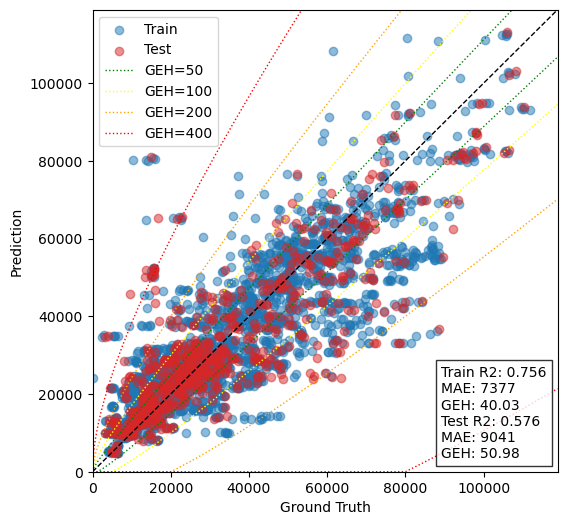

In [6]:
plot_scatter_with_geh_zones(prediction, label, train_test_index)

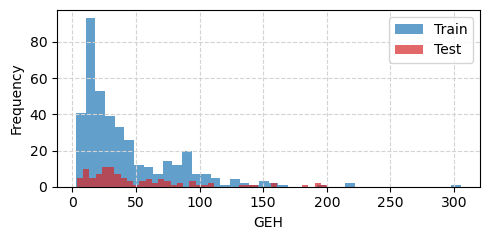

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_geh_individual(y_true, y_pred):
    """Calculate GEH for individual sensors."""
    with np.errstate(divide='ignore', invalid='ignore'):
        diff = np.abs(y_true - y_pred)
        sum_vals = y_true + np.abs(y_pred)
        geh = np.sqrt(2 * (diff**2) / sum_vals)
    return geh

num_sensors = label.shape[1]
train_mask = train_test_index
test_mask = ~train_test_index

# Compute individual GEH for each sensor
geh_values = []
errors = []
for sensor_idx in range(num_sensors):
    y_true = label[:, sensor_idx]
    y_pred = prediction[:, sensor_idx]
    
    # Ignore sensor if all values are NaN
    if np.isnan(y_true).all() or np.isnan(y_pred).all():
        geh_values.append(np.nan)
        continue
    
    # Filter out NaN values
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    geh = calculate_geh_individual(y_true[mask], y_pred[mask])
    geh_values.append(np.nanmean(geh))
    errors.append(np.nanmean(y_pred[mask] - y_true[mask]))

geh_values = np.array(geh_values)
errors = np.array(errors)

# Split GEH values into train and test
train_geh = geh_values[train_mask]
test_geh = geh_values[test_mask]

# Plot histogram
plt.figure(figsize=(5, 2.5))

# Define custom colors
train_color = (31/255, 119/255, 180/255)  # Blue for train
test_color = (214/255, 39/255, 40/255)    # Red for test

plt.hist(train_geh[~np.isnan(train_geh)], bins=40, alpha=0.7, label='Train', color=train_color)
plt.hist(test_geh[~np.isnan(test_geh)], bins=40, alpha=0.7, label='Test', color=test_color)

# Customize plot
# plt.title("Histogram of the mean GEH for Each Sensor over the 8 years")
plt.xlabel("GEH")
plt.ylabel("Frequency")
plt.legend(loc="upper right")

# Add grid with dotted lines
plt.grid(visible=True, which='major', color='lightgray', linestyle='--', linewidth=0.8)

plt.tight_layout()
plt.show()

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_combined_figures_with_gridspec(prediction, label, train_test_index):
    """Plot combined figures using gridspec for layout."""

    # Prepare data for scatter and histogram
    train_mask = train_test_index
    test_mask = ~train_test_index

    # Compute individual GEH for histogram
    num_sensors = label.shape[1]
    geh_values = []
    errors = []
    for sensor_idx in range(num_sensors):
        y_true = label[:, sensor_idx]
        y_pred = prediction[:, sensor_idx]

        if np.isnan(y_true).all() or np.isnan(y_pred).all():
            geh_values.append(np.nan)
            continue

        mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
        geh = calculate_geh_individual(y_true[mask], y_pred[mask])
        geh_values.append(np.nanmean(geh))
        errors.append(np.nanmean(y_pred[mask] - y_true[mask]))

    geh_values = np.array(geh_values)
    errors = np.array(errors)

    # Split GEH values into train and test
    train_geh = geh_values[train_mask]
    test_geh = geh_values[test_mask]

    # Set up gridspec layout
    fig = plt.figure(figsize=(11.5, 5.5))
    gs = fig.add_gridspec(2, 2, width_ratios=[1.2, 1])  # 2 rows, 2 columns

    # Scatter plot (left spanning two rows)
    ax1 = fig.add_subplot(gs[:, 0])  # Spans both rows in the first column
    train_color = (31/255, 119/255, 180/255)  # Blue for train
    test_color = (214/255, 39/255, 40/255)    # Red for test

    pred_flat = prediction.flatten()
    label_flat = label.flatten()
    train_mask_flat = np.repeat(train_mask, prediction.shape[0])
    test_mask_flat = ~train_mask_flat

    train_metrics = calculate_metrics(label[:, train_mask].flatten(), prediction[:, train_mask].flatten())
    test_metrics = calculate_metrics(label[:, test_mask].flatten(), prediction[:, test_mask].flatten())

    ax1.scatter(label_flat[train_mask_flat], pred_flat[train_mask_flat], color=train_color, alpha=0.3, label="Train", s=15)
    ax1.scatter(label_flat[test_mask_flat], pred_flat[test_mask_flat], color=test_color, alpha=0.3, label="Test", s=15)

    max_val = max(np.nanmax(label_flat), np.nanmax(pred_flat)) * 1.05
    ax1.set_xlim(0, max_val)
    ax1.set_ylim(0, max_val)
    ax1.plot([0, max_val], [0, max_val], color='black', linestyle='--', linewidth=1)

    y_vals = np.linspace(0, max_val, 500)
    zones = [
        (50, 'green', "GEH=50"),
        (100, 'yellow', "GEH=100"),
        (200, 'orange', "GEH=200"),
        (400, 'red', "GEH=400"),
    ]
    for geh_value, color, label in zones:
        pred_upper = y_vals + calculate_geh_curve_range(y_vals, geh_value)
        ax1.plot(y_vals, pred_upper, color=color, linestyle=':', linewidth=1, label=label)
        pred_lower = np.maximum(0, y_vals - calculate_geh_curve_range(y_vals, geh_value))
        ax1.plot(y_vals, pred_lower, color=color, linestyle=':', linewidth=1)

    text_str = (
        f"Train MGEH: {train_metrics[2]:.2f}\nTrain MAE: {int(train_metrics[1]):d}\n"
        f"Test MGEH: {test_metrics[2]:.2f}\nTest MAE: {int(test_metrics[1]):d}"
    )
    ax1.text(0.7, 0.03, text_str, transform=ax1.transAxes, fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    ax1.set_xlabel("Ground Truth")
    ax1.set_ylabel("Prediction")
    ax1.legend(loc="upper left")

    # Histogram (top-right)
    ax2 = fig.add_subplot(gs[0, 1])  # Top-right
    ax2.hist(train_geh[~np.isnan(train_geh)], bins=40, alpha=0.9, label='Train', color=train_color)
    ax2.hist(test_geh[~np.isnan(test_geh)], bins=40, alpha=0.9, label='Test', color=test_color)
    ax2.set_xlabel("MGEH of each sensor")
    ax2.set_ylabel("Frequency")
    ax2.legend(loc="upper right")
    ax2.grid(visible=True, which='major', color='lightgray', linestyle='--', linewidth=0.8)

    # Bar plot (bottom-right)
    data = pd.read_csv('best.csv', index_col=0)
    ax3 = fig.add_subplot(gs[1, 1])  # Bottom-right in gridspec
    categories = data.columns  # Extract categories
    mgeh_values = data.loc["MGEH"]  # MGEH values
    mae_values = data.loc["MAE"]  # MAE values
    x = np.arange(len(categories))  # X positions for bars
    width = 0.4  # Width of the bars

    # Define custom colors for bars
    mgeh_color = (214/255, 39/255, 40/255)  # Red for MGEH
    mae_color = (31/255, 119/255, 180/255)  # Blue for MAE

    # Plot MGEH on primary axis
    ax3.bar(x - width/2, mgeh_values, width, label="MGEH", alpha=0.8, color=mgeh_color)

    # Add secondary y-axis for MAE
    ax3_2 = ax3.twinx()
    ax3_2.bar(x + width/2, mae_values, width, label="MAE", alpha=0.8, color=mae_color)

    # Set universal y-axis limits
    ax3.set_ylim(35, 80)  # Y-axis for MGEH
    ax3_2.set_ylim(5500, 18500)  # Y-axis for MAE

    # Set x-axis labels and ticks
    ax3.set_xticks(x)
    ax3.set_xticklabels(categories)
    ax3.set_xlabel("Grouped by Quartiles of Traffic Volume")
    # ax3.set_title("ROI Size")

    # Add legends for both axes
    ax3.legend(loc="upper left")
    ax3_2.legend(loc="upper right")

    # Add grid lines for the primary axis
    ax3.set_axisbelow(True)
    ax3.grid(visible=True, which='major', color='lightgray', linestyle='--', linewidth=0.8)

    plt.tight_layout()
    plt.savefig('eval/yyhat.png')
    plt.show()

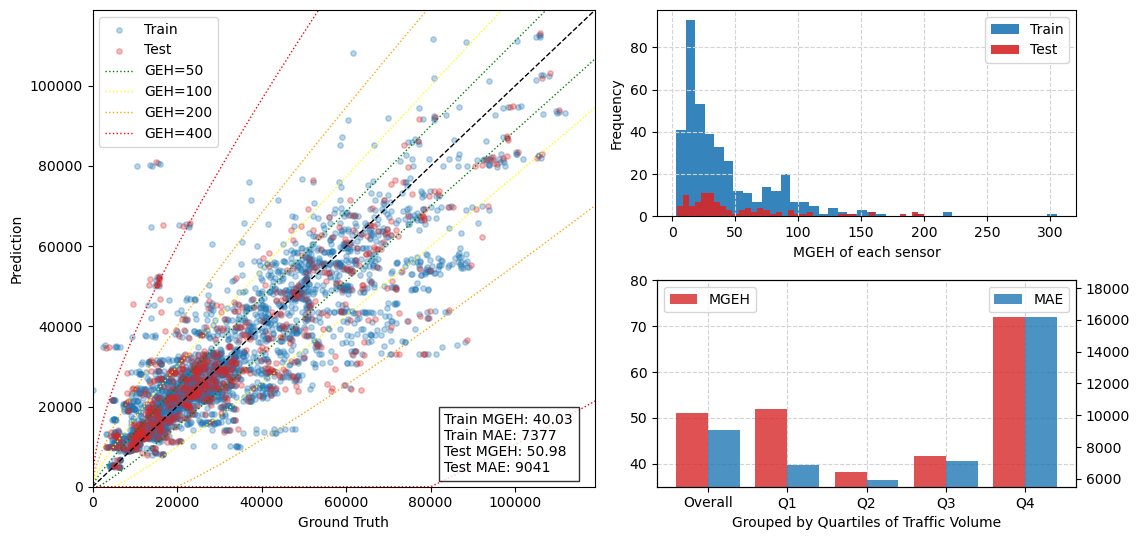

In [48]:
plot_combined_figures_with_gridspec(prediction, label, train_test_index)

In [69]:
percentage = (len([num for num in test_geh if num < 64]) / len(test_geh)) * 100
percentage

72.0

In [21]:
import folium
import polyline
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import branca.colormap as cm
import os
import json
import h5py

# Step 1: Load the data
# Load edge features
edge_features = pd.read_csv("data/highway_network/edge_features.csv")

C:\Users\yueli\AppData\Local\Temp\ipykernel_26324\752035897.py:139: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


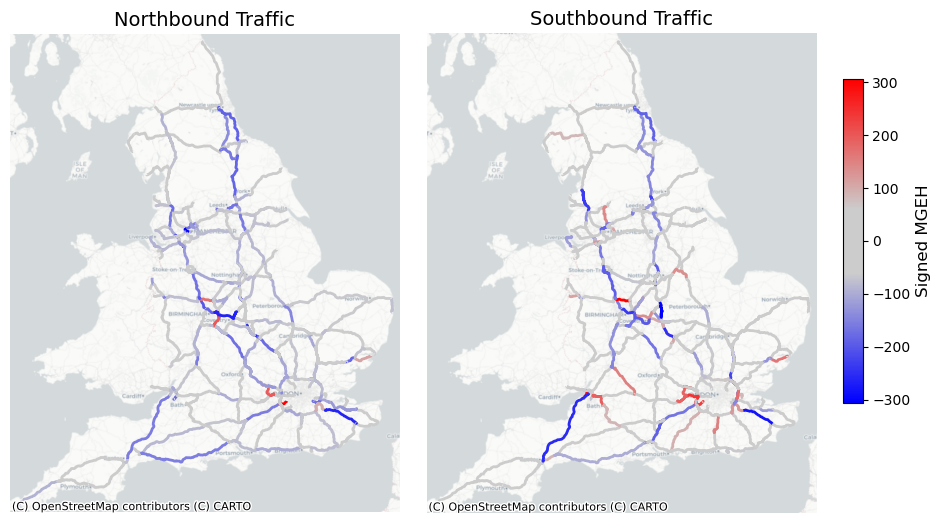

In [70]:
import pandas as pd
import geopandas as gpd
import numpy as np
from shapely.geometry import LineString
import matplotlib.pyplot as plt
import contextily as ctx
import polyline
import matplotlib as mpl

# Step 1: Decode Google Polylines
def decode_google_polyline(polyline_str):
    """
    Decodes a Google Maps polyline string into a Shapely LineString geometry.
    """
    coords = polyline.decode(polyline_str)  # Returns a list of (lat, lon) tuples
    return LineString([(lon, lat) for lat, lon in coords])  # Convert to (lon, lat)

# Step 2: Recalculate Signed GEH
def calculate_signed_geh_array(yhat, y):
    """
    Calculate signed GEH for each year and sensor.
    
    Parameters:
    yhat (ndarray): Predicted values, shape (8, 498)
    y (ndarray): Ground truth values, shape (8, 498)
    
    Returns:
    signed_geh (ndarray): Signed GEH values, shape (8, 498)
    """
    epsilon = 1e-10  # Small value to avoid division by zero
    diff = yhat - y
    sign = np.sign(diff)  # 1 for overestimation, -1 for underestimation
    signed_geh = np.sqrt(2 * (diff**2) / (yhat + y + epsilon)) * sign
    return signed_geh

# Step 3: Classify Direction
def classify_direction(row):
    """Classify direction as northbound or southbound based on geometry."""
    line = row['geometry']
    if line.coords[0][1] < line.coords[-1][1]:  # Check latitude
        return 'Northbound'
    else:
        return 'Southbound'

# Load and prepare data
# edge_features should be a DataFrame containing at least these columns:
# 'Polyline', 'Origin', 'Destination', 'Observed', 'Predicted'
# Replace `edge_features` with your actual data.

# Example data loading
# edge_features = pd.read_csv("path_to_your_edge_features.csv")

# Apply decoding to create geometry column
edge_features['geometry'] = edge_features['Polyline'].apply(decode_google_polyline)

# Create GeoDataFrame
gdf = gpd.GeoDataFrame(edge_features, geometry='geometry', crs="EPSG:4326")

# Recalculate GEH for all years and sensors
# `prediction` and `label` are arrays of shape (8, 498)
# Ensure prediction and label are scaled and converted to numpy arrays before using.

signed_geh = calculate_signed_geh_array(prediction, label)  # Shape (8, 498)
average_signed_geh = np.nanmean(signed_geh, axis=0)  # Shape (498,)

# Add averaged signed GEH to gdf
gdf['SignedGEH'] = average_signed_geh

# Normalize Signed GEH for visualization
max_signed_geh = np.abs(gdf['SignedGEH']).max()  # Get absolute max for symmetric scaling
gdf['NormalizedGEH'] = gdf['SignedGEH'] / max_signed_geh  # Scale between -1 and 1

# Classify directions and separate GeoDataFrames
gdf['Direction'] = gdf.apply(classify_direction, axis=1)
northbound_gdf = gdf[gdf['Direction'] == 'Northbound']
southbound_gdf = gdf[gdf['Direction'] == 'Southbound']

# Reproject to EPSG:27700 (British National Grid)
northbound_gdf = northbound_gdf.to_crs("EPSG:27700")
southbound_gdf = southbound_gdf.to_crs("EPSG:27700")

import matplotlib.colors as mcolors

# Step 1: Create a custom colormap with white or gray at the center
custom_colors = {
    'red':   [(0.0, 0.0, 0.0),  # Pure blue (underestimation)
              (0.4, 0.8, 0.8),  # Transition to gray starts earlier
              (0.6, 0.8, 0.8),  # Gray (R=0.8) stays longer
              (1.0, 1.0, 1.0)],  # Pure red (overestimation)
    'green': [(0.0, 0.0, 0.0),
              (0.4, 0.8, 0.8),  # Transition to gray starts earlier
              (0.6, 0.8, 0.8),  # Gray (G=0.8) stays longer
              (1.0, 0.0, 0.0)],
    'blue':  [(0.0, 1.0, 1.0),
              (0.4, 0.8, 0.8),  # Transition to gray starts earlier
              (0.6, 0.8, 0.8),  # Gray (B=0.8) stays longer
              (1.0, 0.0, 0.0)],
}
custom_cmap = mcolors.LinearSegmentedColormap('CustomBlueWhiteRed', custom_colors)

import matplotlib.gridspec as gridspec

# Create a gridspec layout for better control over subplot positions
fig = plt.figure(figsize=(11, 7))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.05], wspace=0.1)  # Adjust `wspace` to control spacing

# Northbound Map
ax1 = fig.add_subplot(gs[0, 0])
northbound_gdf.plot(ax=ax1, column='NormalizedGEH', cmap=custom_cmap, linewidth=2, legend=False)
ctx.add_basemap(ax1, crs=northbound_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax1.set_xlim(northbound_gdf.total_bounds[0] - 10000, northbound_gdf.total_bounds[2] + 10000)
ax1.set_ylim(northbound_gdf.total_bounds[1] - 10000, northbound_gdf.total_bounds[3] + 10000)
ax1.axis('off')
ax1.set_title('Northbound Traffic', fontsize=14)

# Southbound Map
ax2 = fig.add_subplot(gs[0, 1])
southbound_gdf.plot(ax=ax2, column='NormalizedGEH', cmap=custom_cmap, linewidth=2, legend=False)
ctx.add_basemap(ax2, crs=southbound_gdf.crs.to_string(), source=ctx.providers.CartoDB.Positron)
ax2.set_xlim(southbound_gdf.total_bounds[0] - 10000, southbound_gdf.total_bounds[2] + 10000)
ax2.set_ylim(southbound_gdf.total_bounds[1] - 10000, southbound_gdf.total_bounds[3] + 10000)
ax2.axis('off')
ax2.set_title('Southbound Traffic', fontsize=14)

# Colorbar
# Create the colorbar axis with custom bounds to make it shorter
cax = fig.add_subplot(gs[0, 2])  # Place colorbar in the third column
box = cax.get_position()  # Get current position of the colorbar axis
cax.set_position([box.x0, box.y0 + 0.2, box.width, box.height * 0.6])  # Shrink height to 60% and move it up

# Create the colorbar
norm = mpl.colors.Normalize(vmin=-max_signed_geh, vmax=max_signed_geh)
sm = mpl.cm.ScalarMappable(cmap=custom_cmap, norm=norm)
sm._A = []
cbar = fig.colorbar(sm, cax=cax, orientation="vertical")
cbar.set_label('Signed MGEH', fontsize=12)

# Finalize plot
plt.tight_layout()
plt.savefig('eval/Traffic_Direction_SignedGEH_Compact.png', bbox_inches='tight', pad_inches=0)
plt.show()

In [ ]:
### feature importance

In [1]:
import os
import subprocess
from tqdm import tqdm

# Read the template configuration
def read_config_template(template_path):
    with open(template_path, 'r') as file:
        return file.readlines()

# Modify the configuration
def modify_config(template_lines, changes):
    modified_lines = []
    for line in template_lines:
        for key, value in changes.items():
            if key in line:
                line = f"{key}: {value},\n"
        modified_lines.append(line)
    return modified_lines

# Write the modified configuration
def write_config(output_path, modified_lines):
    with open(output_path, 'w') as file:
        file.writelines(modified_lines)

# Automate training and log handling
def change_config(changes):
    # Read and modify the config
    template_lines = read_config_template("config_template.py")
    modified_lines = modify_config(template_lines, changes)
    write_config("config.py", modified_lines)

In [2]:
# {"log_name": "best-no-emp.log", "changes": {"'employment'": [], "'epoch'": 26, "'step'":6}},
# {"log_name": "best-no-pop.log", "changes": {"'population'": [], "'epoch'": 21, "'step'":5}},
# {"log_name": "best-no-land_use.log", "changes": {"'landuse_poi'": list(range(4,12)), "'epoch'": 37, "'step'":7}},
# {"log_name": "best-no-road_network.log", "changes": {"'landuse_poi'": list(range(4))+list(range(7,12)), "'epoch'": 21, "'step'":2}},
# {"log_name": "best-no-poi.log", "changes": {"'landuse_poi'": list(range(7)), "'epoch'": 29, "'step'":5}},
# {"log_name": "best-no-edge_features.log", "changes": {"'model'": "'model_no_edge_features'", "'epoch'": 42, "'step'":1}},

In [3]:
change_config({"'model'": "'model_no_edge_features'"})
name = "best-no-edge_features"

import tensorflow as tf
# To disable all GPUs
tf.config.set_visible_devices([], 'GPU')

import numpy as np
np.set_printoptions(formatter={'float': '{: 0.2f}'.format})
import random

from config import TRAINING, MODEL
import importlib
imported_module = importlib.import_module(f"model.{MODEL['model']}")
Model = getattr(imported_module, "Model")
from model.dataloader import get_gt, get_static_features
import model.utils as utils

np.random.seed(TRAINING['seed'])
tf.random.set_seed(TRAINING['seed'])
random.seed(TRAINING['seed'])

np.random.seed(TRAINING['seed'])
tf.random.set_seed(TRAINING['seed'])
random.seed(TRAINING['seed'])

# initialize model
g = Model() 

# Data setup
label, scaler = get_gt() # (8, 498)
grid_static_features = get_static_features() # (8, 653, 574, 2)
train_test_index = utils.train_test_sampler((label.shape[1],), TRAINING['train_prop'])

# Load model
temp = g(grid_static_features[0:1])
g.load_weights(f'param/{name}.h5')

Mean: 33734.9375 Standard Deviation: 23736.3809
Grid features shape (8, 653, 573, 14)


In [4]:
prediction = []
for y in range(grid_static_features.shape[0]):  # each year as a step
    pred = g(grid_static_features[y:y+1, ...])
    prediction.append(pred)
prediction = tf.stack(prediction, axis=0)

prediction = scaler.inverse_transform(prediction).numpy()
label = scaler.inverse_transform(label).numpy()
train_test_index = train_test_index.numpy()

In [5]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error

# Function to calculate GEH
def calculate_geh(y_true, y_pred):
    """Calculate GEH for predictions."""
    diff = np.abs(y_true - y_pred)
    sum_vals = y_true + np.abs(y_pred)
    geh = np.sqrt(2 * (diff**2) / sum_vals)
    return np.mean(geh)

# Function to calculate MAE and GEH metrics
def calculate_metrics(y_true, y_pred):
    """Calculate MAE and GEH metrics."""
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]
    mae = mean_absolute_error(y_true_filtered, y_pred_filtered)
    geh = calculate_geh(y_true_filtered, y_pred_filtered)
    return mae, geh

# Filter only test sensors
test_sensors = ~train_test_index  # Test sensors indicated as False
prediction_test = prediction[:, test_sensors].flatten()
label_test = label[:, test_sensors].flatten()

# Mask out NaN values
mask = ~np.isnan(label_test)
prediction_filtered = prediction_test[mask]
label_filtered = label_test[mask]

# Calculate tertile thresholds
tertiles = np.percentile(label_filtered, [33.33, 66.67])

# Group indices by tertiles
groups = [
    label_filtered < tertiles[0],  # First tertile
    (label_filtered >= tertiles[0]) & (label_filtered < tertiles[1]),  # Second tertile
    label_filtered >= tertiles[1],  # Third tertile
]

# Calculate metrics for all sensors (overall)
overall_mae, overall_geh = calculate_metrics(label_filtered, prediction_filtered)

# Initialize lists for results
mae_results = [overall_mae]
geh_results = [overall_geh]

# Calculate metrics for each tertile group
for group_mask in groups:
    group_label = label_filtered[group_mask]
    group_pred = prediction_filtered[group_mask]
    mae, geh = calculate_metrics(group_label, group_pred)
    mae_results.append(mae)
    geh_results.append(geh)

# Create DataFrame for the results
results = pd.DataFrame({
    "Overall and Tertiles": ["Overall", "T1", "T2", "T3"],
    "MGEH": geh_results,
    "MAE": mae_results
}).set_index("Overall and Tertiles").T

# Save results to CSV
results.to_csv(f"{name}.csv")

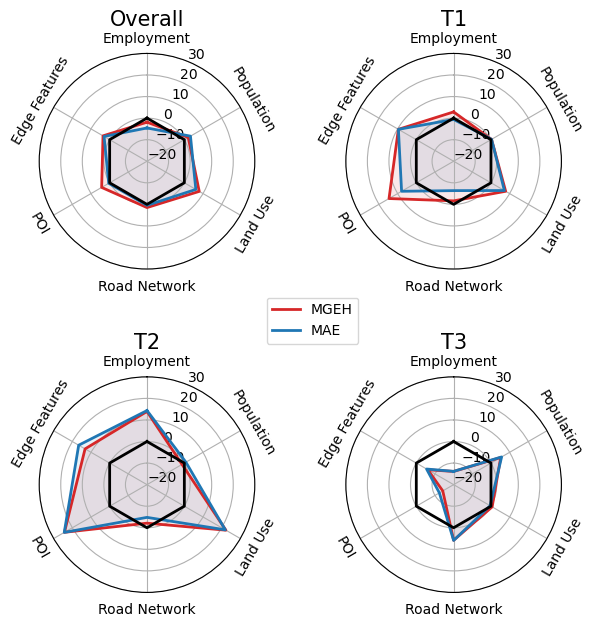

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi

# File paths
files = {
    "Employment": "best-no-emp.csv",
    "Population": "best-no-pop.csv",
    "Land Use": "best-no-land_use.csv",
    "Road Network": "best-no-road_network.csv",
    "POI": "best-no-poi.csv",
    "Edge Features": "best-no-edge_features.csv"
}

# Colors
geh_color = (214 / 255, 39 / 255, 40 / 255)  # RGB for GEH
mae_color = (31 / 255, 119 / 255, 180 / 255)  # RGB for MAE

# Read the baseline data
baseline_file = "best.csv"
baseline_data = pd.read_csv(baseline_file, index_col=0)

# Calculate percentage changes
data = {}
for feature, file_path in files.items():
    feature_data = pd.read_csv(file_path, index_col=0)
    pct_change = 100 * (feature_data - baseline_data) / baseline_data
    data[feature] = pct_change

# Prepare data for plotting
categories = list(files.keys())
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]  # Close the hexagon

yticks = [-20, -10, 0, 10, 20, 30]

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': 'polar'}, figsize=(7, 7))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Rotation mapping
rotation_mapping = {
    "Employment": 0,
    "Population": -60,
    "Land Use": 60,
    "Road Network": 0,
    "POI": -60,
    "Edge Features": 60
}

for idx, col in enumerate(["Overall", "T1", "T2", "T3"]):
    ax = axs[idx // 2, idx % 2]
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Plot data
    mgeh_values = [data[feature].loc["MGEH", col] for feature in categories]
    mgeh_values += mgeh_values[:1]

    mae_values = [data[feature].loc["MAE", col] for feature in categories]
    mae_values += mae_values[:1]

    ax.plot(angles, mgeh_values, color=geh_color, linewidth=2, label="MGEH")
    ax.fill(angles, mgeh_values, color=geh_color, alpha=0.1)

    ax.plot(angles, mae_values, color=mae_color, linewidth=2, label="MAE")
    ax.fill(angles, mae_values, color=mae_color, alpha=0.1)

    # Customize the plot
    ax.set_yticks(yticks)
    ax.yaxis.set_tick_params(width=2)
    ax.set_ylim(min(yticks), max(yticks))
    ax.set_xticks(angles[:-1])

    # Hide default x-tick labels
    ax.set_xticklabels([])

    # Add rotated labels manually
    for i, category in enumerate(categories):
        if category in ["Land Use", "Road Network", "POI"]:
            ax.text(
                angles[i],  # Angle for each label
                ax.get_ylim()[1] + 10,  # Adjust position
                category,  # Actual category name as the label
                fontsize=10,
                ha='center',  # Center the text
                rotation=rotation_mapping[category],  # Apply specified rotation
                rotation_mode='anchor'  # Ensure rotation doesn't append degrees
            )
        else:
            ax.text(
                angles[i],  # Angle for each label
                ax.get_ylim()[1] + 5,  # Adjust position
                category,  # Actual category name as the label
                fontsize=10,
                ha='center',  # Center the text
                rotation=rotation_mapping[category],  # Apply specified rotation
                rotation_mode='anchor'  # Ensure rotation doesn't append degrees
            )

    # Highlight y=0
    ax.plot(angles, [0] * len(angles), color='black', linewidth=2)

    # Title
    ax.set_title(col, size=15, pad=20)

# Add a legend
axs[1, 1].legend(loc='upper left', bbox_to_anchor=(-0.4, 1.4), fontsize=10)

plt.savefig('eval/radar.png')
plt.show()

In [49]:
percentage_changes

{'Employment':        Overall        T1         T2         T3
 MGEH -1.889743  2.879800  13.954344 -13.875366
 MAE  -4.570073 -0.623607  14.361074 -13.840360,
 'Population':        Overall        T1        T2        T3
 MGEH  2.086068  0.289333 -1.242260  5.227485
 MAE   3.281615  0.321882  0.829938  5.696549,
 'Land Use':        Overall        T1         T2        T3
 MGEH  7.971515  7.864333  22.260297  0.621517
 MAE   6.150876  7.178915  21.945836 -0.460551,
 'Road Network':        Overall        T1        T2        T3
 MGEH  1.486989 -1.624569 -2.126834  5.808609
 MAE   0.451541 -6.371306 -4.817175  5.870625,
 'POI':        Overall         T1         T2         T3
 MGEH  4.284609  14.604482  24.218404 -14.183725
 MAE   0.495408   7.873830  24.311803 -12.364119,
 'Edge Features':        Overall        T1         T2        T3
 MGEH  3.560089  9.588555  13.169811 -6.169727
 MAE   3.001293  9.585127  16.586929 -5.512050}